Compiling model...
Building feed-forward neural network...
'build' took 0.056997 s

'compile' took 0.883091 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.08e-02, 3.07e-03, 3.36e-03, 8.87e+04, 2.50e+05, 8.88e+04]    [1.08e-02, 3.07e-03, 3.36e-03, 8.87e+04, 2.50e+05, 8.88e+04]    []  
1000      [1.15e-02, 4.73e-06, 1.46e-06, 6.13e+04, 2.02e+05, 6.13e+04]    [1.15e-02, 4.73e-06, 1.46e-06, 6.13e+04, 2.02e+05, 6.13e+04]    []  
2000      [1.15e-03, 4.40e-07, 1.32e-07, 4.38e+04, 1.69e+05, 4.38e+04]    [1.15e-03, 4.40e-07, 1.32e-07, 4.38e+04, 1.69e+05, 4.38e+04]    []  
3000      [2.51e-04, 9.39e-08, 2.77e-08, 2.97e+04, 1.40e+05, 2.97e+04]    [2.51e-04, 9.39e-08, 2.77e-08, 2.97e+04, 1.40e+05, 2.97e+04]    []  
4000      [7.73e-05, 2.86e-08, 8.35e-09, 1.87e+04, 1.15e+05, 1.87e+04]    [7.73e-05, 2.86e-08, 8.35e-09, 1.87e+04, 1.15e+05, 1.87e+04]    []  
5000 

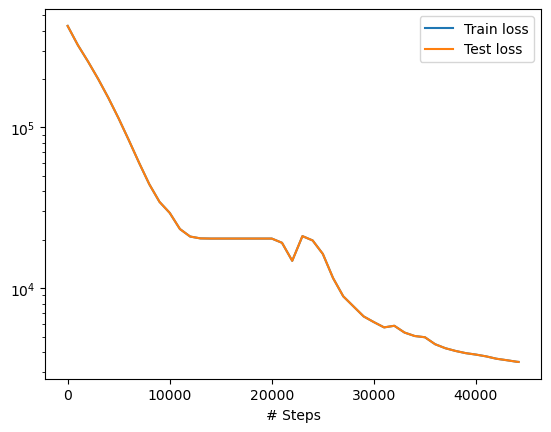

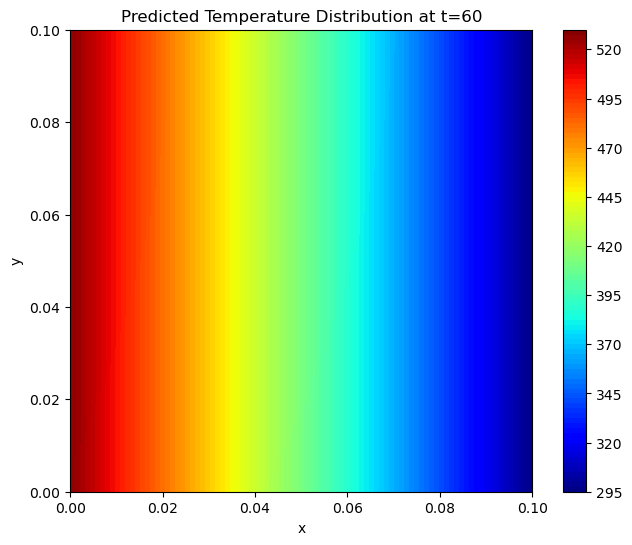

In [2]:
import deepxde as dde 
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt



# Problem parameters:(Material: Carbon fibre epoxy)

a = 1             # (m^2/s) Thermal diffusivity
W = 0.1           # (m) Width of the geometry
H = 0.1           # (m) Height of the geometry


# PDE residual
'''
   X_j = [x, y, t] = {space , time} j = 0,1,2
   u_i = [u_x, u_y],  i=0,1
''' 

def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=2)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    return du_t - a * (du_xx + du_yy)


# Computational geometry:60*20 rectangle
geom = dde.geometry.Rectangle([0, 0], [W, H])
timedomain = dde.geometry.TimeDomain(0, 60)    # time is in seconds 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Defining Boundaries
''' x[0]: x-axis
    x[1]: y-axis
'''
def boundary_t (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], H)
def boundary_b (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0)
def boundary_r (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], W)
def boundary_l (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)


# Initial and boundary conditions:
bc_l = dde.DirichletBC(geomtime, lambda x: 500, boundary_l)
bc_r = dde.DirichletBC(geomtime, lambda x: 298, boundary_r)
bc_b = dde.icbc.NeumannBC(geomtime, lambda X: 0, boundary_b)               #Neumann (Zero flux)
bc_t = dde.icbc.NeumannBC(geomtime, lambda X: 0, boundary_t)               #Neumann (Zero flux)
 
ic = dde.icbc.IC(geomtime,lambda x:298,lambda _, on_initial: on_initial)

# Define the PDE problem and configurations of the network:

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_b, bc_t, bc_r, bc_l,ic],
    num_domain=4500,
    num_boundary=1200,
    num_initial=1200,
)

# NN
layer_size = [3] + [40] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=35000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# spatial grid
x = np.linspace(0, W, 40)  # Spatial grid points in x
y = np.linspace(0, H, 20)  # Spatial grid points in y
X, Y = np.meshgrid(x, y)

# specific time for prediction
specific_time = 60
T = np.full(X.shape, specific_time)  # Create a grid of the specific time

# Flatten the grid for prediction
test_grid = np.vstack((X.flatten(), Y.flatten(), T.flatten())).T

# Predict the solution
u_pred = model.predict(test_grid)
u_pred = u_pred.reshape(X.shape)  # Reshape back to 2D grid
# Plot the predicted solution
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_pred, levels=100, cmap='jet')
plt.colorbar()
plt.title(f'Predicted Temperature Distribution at t={specific_time}')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')  # Enforce equal aspect ratio
plt.show()